In [2]:
# %load /Users/dlenz/.jupyter/startup.py
# Standard magic commands
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Default imports
import sys
import os
import itertools as it

import matplotlib.pyplot as plt
import pandas as pd
import healpy as hp
import numpy as np
import tables
from astropy.io import fits
import seaborn as sns
from matplotlib.colors import LogNorm
import yaml

from myhelpers import misc, hpx, plots
from myhelpers import equations as eq
from myhelpers import coordinates as coords
from myhelpers.datasets import hi4pi, planck_pr2 as ppr2

# Settings
sns.set_style('whitegrid')
sns.set_palette('colorblind')

# Show all output values
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"


In [96]:
# %load /Users/dlenz/.jupyter/bokeh.py
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import LinearColorMapper, BasicTicker, ColorBar
from bokeh.palettes import Dark2_5
from itertools import cycle
colors = cycle(Dark2_5)

output_notebook()


Loading BokehJS ...

In [89]:
import site
site.addsitedir(misc.bpjoin('edges'))

from src import data, utils, models

In [92]:
from scipy.optimize import curve_fit, minimize

# Objective

We will generate samples that reflect the uncertainty in the gaincurve, shown in the figure below. This is taken from the Bowman+ (2018) paper.

![title](../figures/external/gaincurve_residuals.png)

In [20]:
freqs = df_fig1['freq'].values

# Load data

In [6]:
df_fig1 = data.fetch_fig1()

In [11]:
nchans = df_fig1['freq'].shape[0]

In [275]:
def get_gaincurves(freqs, n_samples=10):
    nchans = freqs.shape[0]
    
    # Get randomized amplitude
    amps = 0.5e-2 * np.random.randn(n_samples)
    
    # Get randomized phases
    phases = np.random.rand(n_samples) * 2. * np.pi
    
    # Get randomized period
    periods = 0.5 * np.random.randn(n_samples) + 4.
    
    def get_gaincurve(amp, phase, period):
        return 1. + amp * np.sin((freqs - phase)/period)

    gaincurves = np.array([get_gaincurve(
        amp, phase, period) for amp, phase, period in zip(amps, phases, periods)])
#     gaincurves = 1. + amps * np.sin((freqs - phases)/periods)
    
    return gaincurves

In [276]:
gaincurves = get_gaincurves(df_fig1['freq'].values)

(0.99, 1.01)

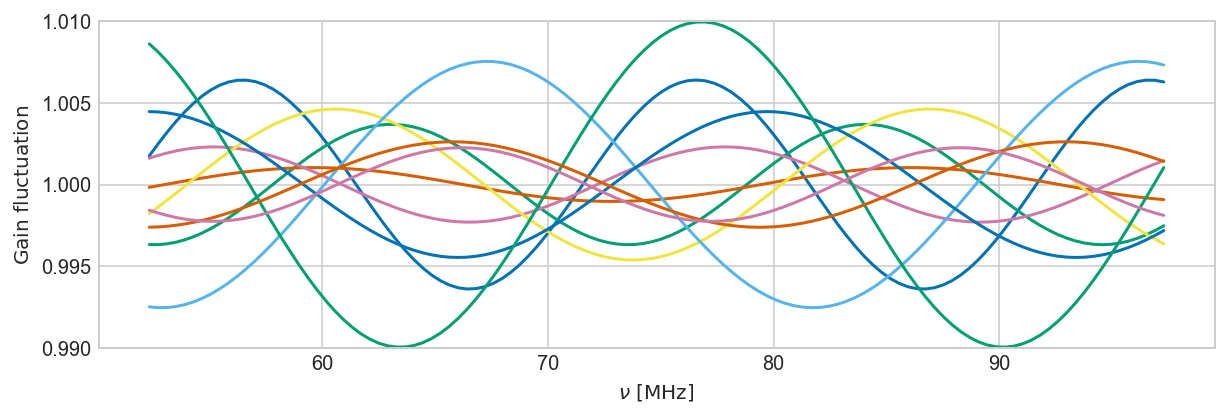

In [278]:
fig, ax = plt.subplots(figsize=(10, 3))

[ax.plot(
    freqs,
    gaincurve) for gaincurve in gaincurves]

ax.set_xlabel(r'$\nu\ [\rm MHz]$')
ax.set_ylabel(r'$\rm Gain\ fluctuation$')

ax.set_ylim(0.99, 1.01)

# Fitting

In [314]:
p0_fg_phys_21cm = np.array([
    -1.09189004e+04, -6.05309574e+03, -1.95126828e+03,  1.60495415e+02,
    1.25091494e+04,  5.37565955e-01,  7.81813030e+01,  7.01412494e+00,
    1.87060209e+01])

In [315]:
gaincurve = get_gaincurves(df_fig1['freq'].values, n_samples=1).ravel()

p_full, cov_full = curve_fit(
    f=models.fg_phys_plus_21cm,
    xdata=df_fig1['freq'].values,
    ydata=df_fig1['tsky'].values*gaincurve,
    p0=p0_fg_phys_21cm,
    sigma=None,
    bounds=(
        (-np.inf, -np.inf, -np.inf, -np.inf, -np.inf, 0., 60., 0., 0.),
        (np.inf, np.inf, np.inf, np.inf, np.inf, 1., 80., np.inf, 30.))
         )

t_sky_full = models.fg_phys_plus_21cm(df_fig1['freq'].values, *p_full)

p_full

array([ 6.51891393e+04,  2.97136491e+04,  9.32693495e+03, -7.58803404e+02,
       -6.26800917e+04,  1.00000000e+00,  6.67930416e+01,  5.49286051e+01,
        1.05463336e+01])

In [316]:
output_notebook()

p = figure(
  plot_width=800, plot_height=500,
  x_range=[50, 100],
  title='Gain curve',
  x_axis_type='linear',
  y_axis_type='linear',
#   y_range=[-0.25, 0.25],
  x_axis_label='Frequency [MHz]',
  y_axis_label='Gain curve')

p.line(
    df_fig1['freq'], gaincurve,
    line_width=1, legend='Gain curve', color='black')

show(p)

# Residual
p = figure(
  plot_width=800, plot_height=500,
  x_range=[50, 100],
  title='T_sky',
  x_axis_type='linear',
  y_axis_type='linear',
  y_range=[-0.25, 0.25],
  x_axis_label='Frequency [MHz]',
  y_axis_label='Delta T_sky [K]')

p.line(
    df_fig1['freq'], df_fig1['tsky']*gaincurve - t_sky_full,
    line_width=1, legend='Data - full model', color='black')

show(p)

# Model
t21_model = models.model_hi_trough(df_fig1['freq'].values, *p_full[-4:])

p = figure(
  plot_width=800, plot_height=500,
  x_range=[50, 100],
  title='HI trough',
  x_axis_type='linear',
  y_axis_type='linear',
#   y_range=[-0.25, 0.25],
  x_axis_label='Frequency [MHz]',
  y_axis_label='HI signal [K]')

# Model
p.line(
    df_fig1['freq'], t21_model,
    line_width=1, legend='T21 model', color='black')

# Model + Noise
p.line(
    df_fig1['freq'], t21_model + df_fig1['tsky']*gaincurve - t_sky_full,
    line_width=1, legend='T21 model + residual', color='red')

p.legend.location = 'bottom_left'

show(p)

Loading BokehJS ...